In [41]:
# JMF Lab 
# Cell Confluency Analysis and Visualization
# This notebook contains functions to analyze and visualize cell confluency data from 96-well plates. It includes outlier detection, paired comparisons, and bar plots with error bars.
# Lingting Shi

In [ ]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import cv2
import matplotlib as mpl

mpl.rcParams.update({'font.size': 8, 'svg.fonttype': 'none'})
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['xtick.labelsize'] = 8  # Colorbar tick label size
mpl.rcParams['ytick.labelsize'] = 8  # Colorbar tick label size
mpl.rcParams['axes.labelsize'] = 10   # Axis label size
mpl.rcParams['figure.figsize'] = (2, 2)  # width, height in inches

In [ ]:
# Function to analyze cell confluency in a well image
def analyze_cell_confluency(image_path, plot_results=False):
    """
    Analyzes cell confluency in a well image.
    
    Parameters:
    -----------
    image_path : str
        Path to the image file
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'well_area_pixels': Total well area in pixels
        - 'cell_area_pixels': Total cell area in pixels
        - 'proportion_covered': Proportion of well covered by cells (0-1)
        - 'img': Original grayscale image
        - 'final_mask': Final segmented mask
    """
    # --- 1. Load Image ---
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Image not loaded. Check the file path.")
        return None
    else:
        # --- 2. Create a Mask for the Well ---
        # We want to ignore the dark well edge. We'll create a circular mask.
        h, w = img.shape
        center = (w // 2, h // 2)
        # Estimate radius (a bit smaller than the full image half-width/height)
        radius = min(h, w) // 2 - 20 
        
        well_mask = np.zeros_like(img)
        cv2.circle(well_mask, center, radius, 255, -1) # 255 is white, -1 fills the circle
        
        # Calculate the total area of the well (in pixels) for proportion calculation
        well_area_pixels = np.sum(well_mask > 0)
        # --- 3. Adaptive Thresholding (Solves Uneven Illumination) ---
        # This calculates a threshold for small regions, so it's not fooled
        # by the bright center vs. dark edges.
        # cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)
        # blockSize: Size of the neighborhood area (must be odd)
        # C: A constant subtracted from the mean. Fine-tune this value.
        block_size = 51 # Larger block size for smoother transitions
        C = 8           # Tune this: higher C = less sensitive (fewer cells)
        
        binary_mask = cv2.adaptiveThreshold(
            img, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # Use Gaussian mean, it's smoother
            cv2.THRESH_BINARY_INV,         # Invert: cells become white, background black
            block_size, 
            C
        )
        # --- 4. Clean the Mask (Morphological Operations) ---
        # We have a lot of small "pepper" noise.
        # An "Opening" operation (Erode -> Dilate) will remove small white dots.
        kernel_size = 3
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        
        # Opening: Removes small noise (like floating cells/debris)
        clean_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=1)
        
        # (Optional) Closing: Fills small holes *inside* cells
        #clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        # --- 5. Apply the Well Mask ---
        # We only care about cells *inside* the well
        final_mask = cv2.bitwise_and(clean_mask, well_mask)
        # --- 6. Calculate Area and Proportion ---
        cell_area_pixels = cv2.countNonZero(final_mask)
        proportion_covered = cell_area_pixels / well_area_pixels
        
        print(f"--- Cell Area / Proportion Results ---")
        print(f"Total Well Area (pixels): {well_area_pixels}")
        print(f"Total Cell Area (pixels): {cell_area_pixels}")
        print(f"Proportion Covered (Confluency): {proportion_covered:.4f} (or {proportion_covered*100:.2f}%)")
        
        # --- 8. Display Results ---
        # Create overlay: convert grayscale to RGB and add colored mask
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        overlay = img_rgb.copy()
        
        # Add semi-transparent red overlay where cells are detected
        overlay[final_mask > 0] = [255, 0, 0]  # Red color for detected cells
        
        # Blend original and overlay
        alpha = 0.4  # Transparency factor
        img_with_overlay = cv2.addWeighted(img_rgb, 1-alpha, overlay, alpha, 0)
        
        # Create a composite image for display
        plt.figure(figsize=(10, 30))
        
        plt.subplot(3, 1, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 1, 2)
        plt.imshow(final_mask, cmap='gray')
        plt.title(f'Final Segmented Mask ({proportion_covered*100:.2f}% Area)')
        plt.axis('off')
        
        plt.subplot(3, 1, 3)
        plt.imshow(cv2.cvtColor(img_with_overlay, cv2.COLOR_BGR2RGB))
        plt.title(f'Overlay: Red = Detected Cells')
        plt.axis('off')
        
        plt.tight_layout()
        if plot_results:
            plt.show()
        else:
            plt.close()
        
        return {
            'well_area_pixels': well_area_pixels,
            'cell_area_pixels': cell_area_pixels,
            'proportion_covered': proportion_covered,
            'img': img,
            'final_mask': final_mask
        }
        
        # Example usage:
result = analyze_cell_confluency('/home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s73.jpg', plot_results=False)

--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1536326
Proportion Covered (Confluency): 0.1801 (or 18.01%)


# Explore all comparisions

In [ ]:
# Experiment file paths
ex1 = '/home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg'
ex2 = '/home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s{well_number}.jpg'
ex3 = '/home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_11_14_25/Experiment-189/Experiment-189_s{well_number}.jpg'


Comparing CP_10uM_no_T with CP_10uM_with_T

ANALYZING: CP_10uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1736258
Proportion Covered (Confluency): 0.2035 (or 20.35%)
Well 01: 0.20%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1880632
Proportion Covered (Confluency): 0.2204 (or 22.04%)
Well 02: 0.22%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2097794
Proportion Covered (Confluency): 0.2459 (or 24.59%)
Well 03: 0.25%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1441342
Proportion Covered (Confluency): 0.1689 (or 16.89%)
Well 04: 0.17%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186

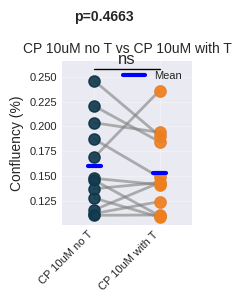

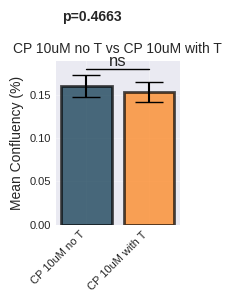


Comparing AL_10uM_no_T with AL_10uM_with_T

ANALYZING: AL_10uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 78049
Proportion Covered (Confluency): 0.0091 (or 0.91%)
Well 05: 0.01%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 57497
Proportion Covered (Confluency): 0.0067 (or 0.67%)
Well 06: 0.01%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 36460
Proportion Covered (Confluency): 0.0043 (or 0.43%)
Well 07: 0.00%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 75664
Proportion Covered (Confluency): 0.0089 (or 0.89%)
Well 08: 0.01%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s{well_numb

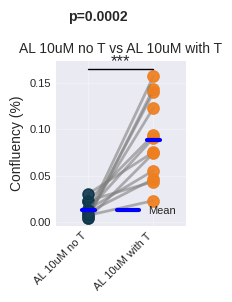

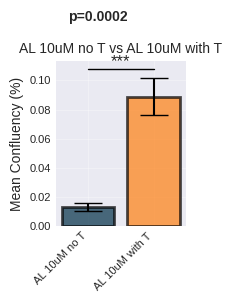


Comparing Combined_10uM_no_T with Combined_10uM_with_T

ANALYZING: Combined_10uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 194188
Proportion Covered (Confluency): 0.0228 (or 2.28%)
Well 09: 0.02%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 154460
Proportion Covered (Confluency): 0.0181 (or 1.81%)
Well 10: 0.02%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 72753
Proportion Covered (Confluency): 0.0085 (or 0.85%)
Well 11: 0.01%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 358765
Proportion Covered (Confluency): 

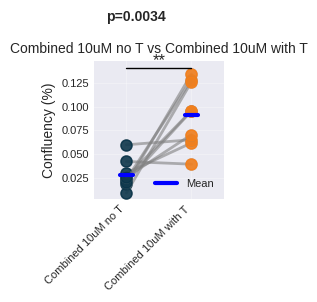

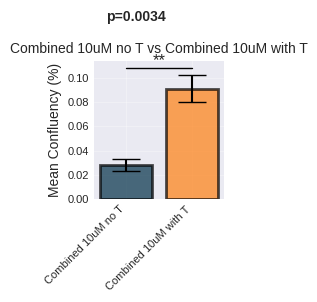


Comparing CP_1uM_no_T with CP_1uM_with_T

ANALYZING: CP_1uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1984319
Proportion Covered (Confluency): 0.2326 (or 23.26%)
Well 24: 0.23%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2452423
Proportion Covered (Confluency): 0.2874 (or 28.74%)
Well 23: 0.29%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2310597
Proportion Covered (Confluency): 0.2708 (or 27.08%)
Well 22: 0.27%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2366066
Proportion Covered (Confluency): 0.2773 (or 27.73%)
Well 21: 0.28%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s{

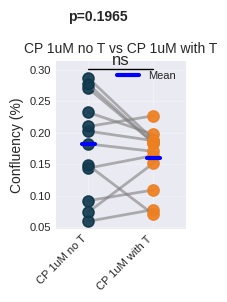

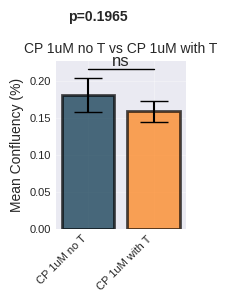


Comparing AL_1uM_no_T with AL_1uM_with_T

ANALYZING: AL_1uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1879555
Proportion Covered (Confluency): 0.2203 (or 22.03%)
Well 20: 0.22%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1485269
Proportion Covered (Confluency): 0.1741 (or 17.41%)
Well 19: 0.17%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1052661
Proportion Covered (Confluency): 0.1234 (or 12.34%)
Well 18: 0.12%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1233223
Proportion Covered (Confluency): 0.1445 (or 14.45%)
Well 17: 0.14%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s{

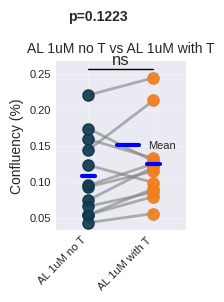

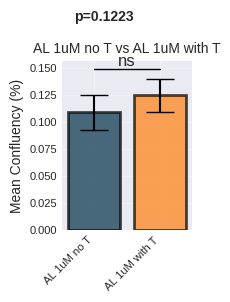


Comparing Combined_1uM_no_T with Combined_1uM_with_T

ANALYZING: Combined_1uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 863055
Proportion Covered (Confluency): 0.1012 (or 10.12%)
Well 16: 0.10%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 695819
Proportion Covered (Confluency): 0.0816 (or 8.16%)
Well 15: 0.08%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 765984
Proportion Covered (Confluency): 0.0898 (or 8.98%)
Well 14: 0.09%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 775283
Proportion Covered (Confluency): 0

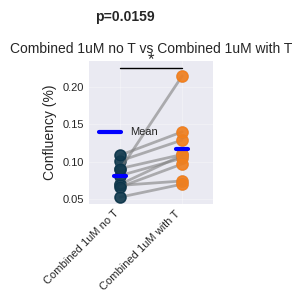

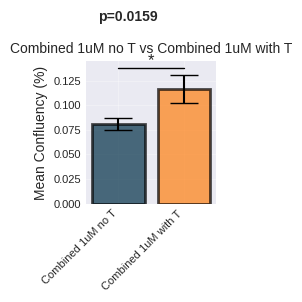


Comparing CP_0.1uM_no_T with CP_0.1uM_with_T

ANALYZING: CP_0.1uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1324099
Proportion Covered (Confluency): 0.1552 (or 15.52%)
Well 25: 0.16%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 3179367
Proportion Covered (Confluency): 0.3726 (or 37.26%)
Well 26: 0.37%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1634042
Proportion Covered (Confluency): 0.1915 (or 19.15%)
Well 27: 0.19%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2477486
Proportion Covered (Confluency): 0.2904 (or 29.04%)
Well 28: 0.29%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-

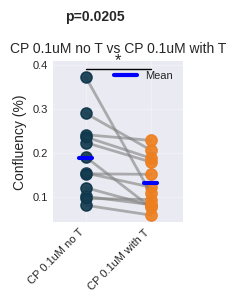

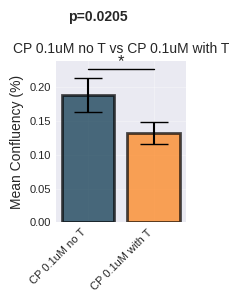


Comparing AL_0.1uM_no_T with AL_0.1uM_with_T

ANALYZING: AL_0.1uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 3381561
Proportion Covered (Confluency): 0.3963 (or 39.63%)
Well 29: 0.40%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 3002601
Proportion Covered (Confluency): 0.3519 (or 35.19%)
Well 30: 0.35%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2243315
Proportion Covered (Confluency): 0.2629 (or 26.29%)
Well 31: 0.26%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 3129210
Proportion Covered (Confluency): 0.3668 (or 36.68%)
Well 32: 0.37%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-

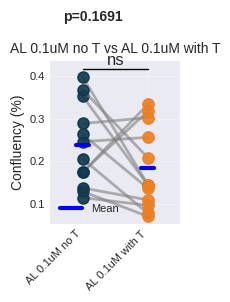

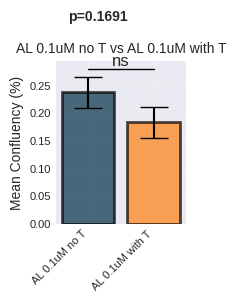


Comparing Combined_0.1uM_no_T with Combined_0.1uM_with_T

ANALYZING: Combined_0.1uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2325851
Proportion Covered (Confluency): 0.2726 (or 27.26%)
Well 33: 0.27%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2485100
Proportion Covered (Confluency): 0.2913 (or 29.13%)
Well 34: 0.29%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2819523
Proportion Covered (Confluency): 0.3305 (or 33.05%)
Well 35: 0.33%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2108566
Proportion Covered (Co

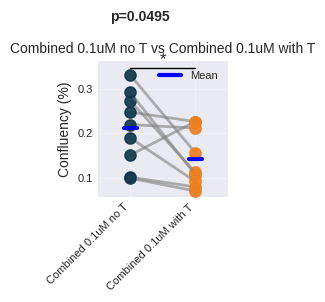

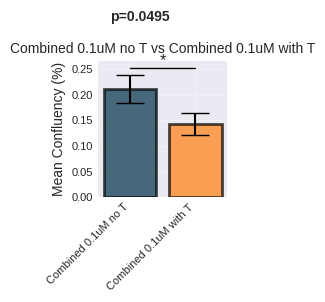


Comparing CP_0.01uM_no_T with CP_0.01uM_with_T

ANALYZING: CP_0.01uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2412477
Proportion Covered (Confluency): 0.2828 (or 28.28%)
Well 48: 0.28%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1973512
Proportion Covered (Confluency): 0.2313 (or 23.13%)
Well 47: 0.23%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1366934
Proportion Covered (Confluency): 0.1602 (or 16.02%)
Well 46: 0.16%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2122434
Proportion Covered (Confluency): 0.2488 (or 24.88%)
Well 45: 0.25%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experime

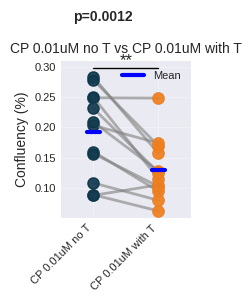

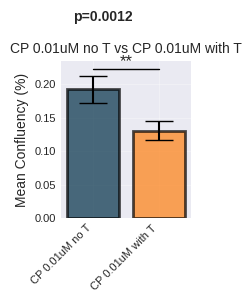


Comparing AL_0.01uM_no_T with AL_0.01uM_with_T

ANALYZING: AL_0.01uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2139691
Proportion Covered (Confluency): 0.2508 (or 25.08%)
Well 44: 0.25%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2219862
Proportion Covered (Confluency): 0.2602 (or 26.02%)
Well 43: 0.26%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1969804
Proportion Covered (Confluency): 0.2309 (or 23.09%)
Well 42: 0.23%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2410340
Proportion Covered (Confluency): 0.2825 (or 28.25%)
Well 41: 0.28%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experime

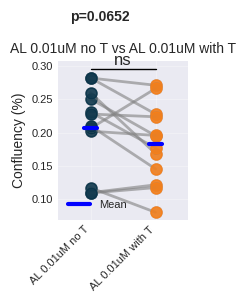

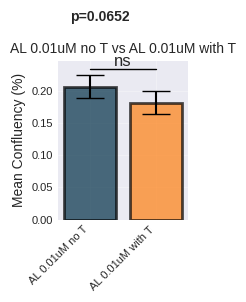


Comparing Combined_0.01uM_no_T with Combined_0.01uM_with_T

ANALYZING: Combined_0.01uM_no_T

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1080215
Proportion Covered (Confluency): 0.1266 (or 12.66%)
Well 40: 0.13%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1567517
Proportion Covered (Confluency): 0.1837 (or 18.37%)
Well 39: 0.18%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2073318
Proportion Covered (Confluency): 0.2430 (or 24.30%)
Well 38: 0.24%

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_31_25/Experiment-186/Experiment-186_s{well_number}.jpg ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1409737
Proportion Covered 

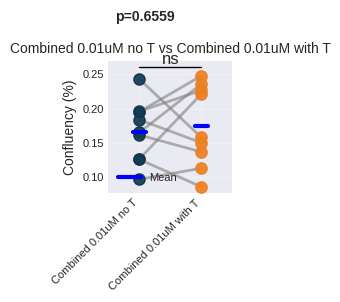

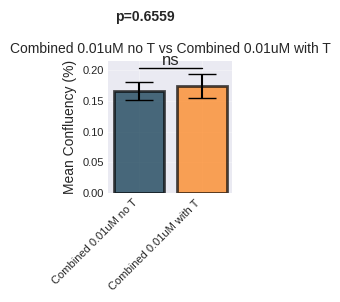

In [27]:
import itertools
# Well plate layout dictionary
WELL_PLATE_LAYOUT = {
    # CP no T cells (columns 1-4)
    'CP_10uM_no_T': ['01', '02', '03', '04'],
    'CP_1uM_no_T': ['24', '23', '22', '21'],
    'CP_0.1uM_no_T': ['25', '26', '27', '28'],
    'CP_0.01uM_no_T': ['48', '47', '46', '45'],
    
    # AL no T cells (columns 5-8)
    'AL_10uM_no_T': ['05', '06', '07', '08'],
    'AL_1uM_no_T': ['20', '19', '18', '17'],
    'AL_0.1uM_no_T': ['29', '30', '31', '32'],
    'AL_0.01uM_no_T': ['44', '43', '42', '41'],

     
    # Combined no T cells (columns 9-11)
    'Combined_10uM_no_T': ['09', '10', '11'],
    'Combined_1uM_no_T': ['16', '15', '14'],
    'Combined_0.1uM_no_T': ['33', '34', '35'],
    'Combined_0.01uM_no_T': ['40', '39', '38'],

    
    # CP with T cells (columns 1-4, rows E-H)
    'CP_10uM_with_T': ['49', '50', '51', '52'],
    'CP_1uM_with_T': ['72', '71', '70', '69'],
    'CP_0.1uM_with_T': ['73', '74', '75', '76'],
    'CP_0.01uM_with_T': ['96', '95', '94', '93'],
    
    # AL with T cells (columns 5-8, rows E-H)
    'AL_10uM_with_T': ['53', '54', '55', '56'],
    'AL_1uM_with_T': ['68', '67', '66', '65'],
    'AL_0.1uM_with_T': ['77', '78', '79', '80'],
    'AL_0.01uM_with_T': ['92', '91', '90', '89'],
    
    # Combined with T cells (columns 9-11, rows E-H)
    'Combined_10uM_with_T': ['57', '58', '59'],
    'Combined_1uM_with_T': ['64', '63', '62'],
    'Combined_0.1uM_with_T': ['81', '82', '83'],
    'Combined_0.01uM_with_T': ['88', '87', '86'],
    
}
# Create reverse lookup: well number -> condition
WELL_TO_CONDITION = {}
for condition, wells in WELL_PLATE_LAYOUT.items():
    for well in wells:
        WELL_TO_CONDITION[well] = condition


def compare_conditions(experiments, condition1_key, condition2_key, 
                       analyze_func, comparison_name="Comparison",
                       save_prefix="/home/user/Documents/Kinase_project/Imaging_result/figures/comparison"):
    """
    Flexible function to compare any two conditions from the well plate.
    
    Parameters:
    -----------
    experiments : list
        List of experiment path templates (e.g., [ex1, ex2, ex3])
    condition1_key : str
        Key for first condition from WELL_PLATE_LAYOUT (e.g., 'CP_0.1uM_no_T')
    condition2_key : str
        Key for second condition from WELL_PLATE_LAYOUT (e.g., 'CP_0.1uM_with_T')
    analyze_func : function
        Function to analyze each well (e.g., analyze_cell_confluency)
    comparison_name : str
        Name for the comparison (used in titles)
    save_prefix : str
        Path prefix for saving figures
    
    Returns:
    --------
    dict : Contains results, statistics, and condition information
    """
    
    
    # Get well numbers for each condition
    wells_condition1 = WELL_PLATE_LAYOUT[condition1_key]
    wells_condition2 = WELL_PLATE_LAYOUT[condition2_key]
    
    # Collect results
    results_condition1 = []
    results_condition2 = []
    
    # Analyze condition 1
    print(f"\n{'='*60}")
    print(f"ANALYZING: {condition1_key}")
    print(f"{'='*60}")
    for ex in experiments:
        print(f"\n--- {ex} ---")
        for well_number in wells_condition1:
            path = ex.format(well_number=well_number)
            result = analyze_func(path, plot_results=False)
            if result:
                results_condition1.append(result['proportion_covered'].astype(float))
                print(f"Well {well_number}: {result['proportion_covered']:.2f}%")
    
    # Analyze condition 2
    print(f"\n{'='*60}")
    print(f"ANALYZING: {condition2_key}")
    print(f"{'='*60}")
    for ex in experiments:
        print(f"\n--- {ex} ---")
        for well_number in wells_condition2:
            path = ex.format(well_number=well_number)
            result = analyze_func(path, plot_results=False)
            if result:
                results_condition2.append(result['proportion_covered'].astype(float))
                print(f"Well {well_number}: {result['proportion_covered']:.2f}%")
    
    # Convert to numpy arrays
    data1 = np.array(results_condition1)
    data2 = np.array(results_condition2)
    
    # Statistical analysis
    differences = data1 - data2
    t_stat, p_value = stats.ttest_rel(data1, data2)
    
    # Print statistics
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)
    print(f"\n{condition1_key}:")
    print(f"  Mean: {np.mean(data1):.2f}")
    print(f"  SEM: {np.std(data1, ddof=1)/np.sqrt(len(data1)):.2f}")
    print(f"\n{condition2_key}:")
    print(f"  Mean: {np.mean(data2):.2f}")
    print(f"  SEM: {np.std(data2, ddof=1)/np.sqrt(len(data2)):.2f}")
    print(f"\nMean Difference: {np.mean(differences):.2f}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    # Significance annotation
    if p_value < 0.001:
        sig_text = '***'
    elif p_value < 0.01:
        sig_text = '**'
    elif p_value < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    # Plot 1: Paired line plot
    fig1 = plt.figure(figsize=(2, 3))
    for i in range(len(data1)):
        plt.plot([1, 2], [data1[i], data2[i]], 'o-', alpha=0.6, 
                linewidth=2, markersize=8, color='gray')  # Line in gray
        # Plot individual points with your colors
        plt.plot(1, data1[i], 'o', markersize=8, color='#023047', alpha=0.8)
        plt.plot(2, data2[i], 'o', markersize=8, color='#FF7F11', alpha=0.8)

    plt.xlim(0.5, 2.5)
    plt.xticks([1, 2], [condition1_key.replace('_', ' '), 
                        condition2_key.replace('_', ' ')], 
            rotation=45, ha='right')
    plt.ylabel('Confluency (%)')
    plt.title(comparison_name)
    plt.grid(True, alpha=0.3)
    
    # Add mean lines
    plt.plot([0.9, 1.1], [np.mean(data1), np.mean(data1)], 
            'b-', linewidth=3, label='Mean')
    plt.plot([1.9, 2.1], [np.mean(data2), np.mean(data2)], 
            'b-', linewidth=3)
    plt.legend()
    
    # Statistical annotation
    y_max = max(max(data1), max(data2)) * 1.05
    plt.plot([1, 2], [y_max, y_max], 'k-', linewidth=1)
    plt.text(1.5, y_max * 1.02, sig_text, ha='center', fontsize=12)
    plt.suptitle(f'p={p_value:.4f}', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save line plot
    for ext in ['pdf', 'png', 'svg']:
        plt.savefig(f"{save_prefix}_line.{ext}", 
                   bbox_inches='tight', transparent=True, dpi=900)
    plt.show()
    
    # Plot 2: Bar plot with error bars
    fig2 = plt.figure(figsize=(2, 3))
    means = [np.mean(data1), np.mean(data2)]
    sems = [np.std(data1, ddof=1)/np.sqrt(len(data1)), 
            np.std(data2, ddof=1)/np.sqrt(len(data2))]
    
    x_pos = [1, 2]
    plt.bar(x_pos, means, yerr=sems, capsize=10, 
           color=['#023047', '#FF7F11'], 
           alpha=0.7, edgecolor='black', linewidth=2)
    
    plt.xticks(x_pos, [condition1_key.replace('_', ' '), 
                       condition2_key.replace('_', ' ')], 
              rotation=45, ha='right')
    plt.ylabel('Mean Confluency (%)')
    plt.title(comparison_name)
    plt.grid(True, alpha=0.3)
    
    # Statistical annotation
    y_max = max(means) + max(sems) * 1.5
    plt.plot([1, 2], [y_max, y_max], 'k-', linewidth=1)
    plt.text(1.5, y_max * 1.02, sig_text, ha='center', fontsize=12)
    plt.suptitle(f'p={p_value:.4f}', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save bar plot
    for ext in ['pdf', 'png', 'svg']:
        plt.savefig(f"{save_prefix}_bar.{ext}", 
                   bbox_inches='tight', transparent=True, dpi=900)
    plt.show()
    
    # Return comprehensive results
    return {
        'condition1': condition1_key,
        'condition2': condition2_key,
        'data1': data1,
        'data2': data2,
        't_statistic': t_stat,
        'p_value': p_value,
        'significance': sig_text,
        'mean1': np.mean(data1),
        'mean2': np.mean(data2),
        'sem1': sems[0],
        'sem2': sems[1]
    }


# Compare with_T vs no_T for each drug and concentration combination
for dose in ['10uM', '1uM', '0.1uM', '0.01uM']:
    drugs = ['CP', 'AL', 'Combined']
    for drug in drugs:
        cond1 = f"{drug}_{dose}_no_T"
        cond2 = f"{drug}_{dose}_with_T"
        
        # Only compare if both conditions exist in the layout
        if cond1 in WELL_PLATE_LAYOUT and cond2 in WELL_PLATE_LAYOUT:
            comparison_name = f"{cond1.replace('_', ' ')} vs {cond2.replace('_', ' ')}"
            save_prefix = f"/home/user/Documents/Kinase_project/Imaging_result/figures/{cond1}_vs_{cond2}"
            print(f"\nComparing {cond1} with {cond2}")
            result = compare_conditions(
                experiments=[ex1, ex2, ex3],
                condition1_key=cond1,
                condition2_key=cond2,
                analyze_func=analyze_cell_confluency,
                comparison_name=comparison_name,
                save_prefix=save_prefix
            )

In [11]:
Well_numbers_AL_0_01uM_no_T = ['44', '43', '42', '41']
Well_numbers_AL_0_01uM_with_T = ['92', '91', '90', '89']

results_AL_0_01uM_no_T = []
results_AL_0_01uM_with_T = []

# Loop through the experiments
for ex in [ex1, ex2, ex3]:
    print(f"\n--- Processing {ex} ---")
    
    # if ex == ex2:
    #             # Define the well numbers for AL_0.01uM conditions
    #     Well_numbers_AL_0_01uM_no_T = ['44', '43', '42']
    #     Well_numbers_AL_0_01uM_with_T = ['92', '91', '90']
        
    # elif ex == ex1 or ex == ex3:
    #             # Define the well numbers for AL_0.01uM conditions
        

    
    # AL 0.01uM without T-cells
    print(f"\n--- {ex} AL 0.01uM (no T-cells) ---")
    for well_number in Well_numbers_AL_0_01uM_no_T:
        path = ex.format(well_number=well_number)
        result = analyze_cell_confluency(path)
        if result:
            results_AL_0_01uM_no_T.append(result['proportion_covered'].astype(float))
            print(f"Well {well_number}: {result['proportion_covered']:.2f}%")
    
    # AL 0.01uM with T-cells
    print(f"\n--- {ex} AL 0.01uM + T-cells ---")
    for well_number in Well_numbers_AL_0_01uM_with_T:
        path = ex.format(well_number=well_number)
        result = analyze_cell_confluency(path)
        if result:
            results_AL_0_01uM_with_T.append(result['proportion_covered'].astype(float))
            print(f"Well {well_number}: {result['proportion_covered']:.2f}%")

# Statistical comparison
from scipy import stats

print(f"\n=== Statistical Comparison ===")
print(f"AL 0.1uM no T-cells: mean = {np.mean(results_AL_0_01uM_no_T):.2f}%, std = {np.std(results_AL_0_01uM_no_T):.2f}%")
print(f"AL 0.1uM with T-cells: mean = {np.mean(results_AL_0_01uM_with_T):.2f}%, std = {np.std(results_AL_0_01uM_with_T):.2f}%")

# Perform t-test
t_stat, p_value = stats.ttest_ind(results_AL_0_01uM_no_T, results_AL_0_01uM_with_T)
print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}")


--- Processing /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---

--- /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg AL 0.01uM (no T-cells) ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2139691
Proportion Covered (Confluency): 0.2508 (or 25.08%)
Well 44: 0.25%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2219862
Proportion Covered (Confluency): 0.2602 (or 26.02%)
Well 43: 0.26%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1969804
Proportion Covered (Confluency): 0.2309 (or 23.09%)
Well 42: 0.23%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2410340
Proportion Covered (Confluency): 0.2825 (or 28.25%)
Well 41: 0.28%

--- /home/user/Documents/

In [42]:
# Figure productions of DMSO comparisons and AL 0.01uM comparisons with and without T-cells (outlier removed)

In [43]:
def detect_outliers_pairwise(data1, data2, method='zscore', threshold=3):
    """
    Detect outliers in paired data for pairwise comparisons.
    
    Parameters:
    -----------
    data1, data2 : array-like
        Paired measurements from two conditions
    method : str
        'zscore' - Z-score method on differences
        'iqr' - Interquartile range method on differences
        'grubbs' - Grubbs test on differences
    threshold : float
        Threshold for outlier detection (default=3 for zscore, 1.5 for IQR)
    
    Returns:
    --------
    dict containing outlier indices and cleaned data
    """
    
    data1 = np.array(data1)
    data2 = np.array(data2)
    differences = data1 - data2
    
    outlier_indices = []
    
    if method == 'zscore':
        # Z-score method on differences
        z_scores = np.abs(stats.zscore(differences))
        outlier_indices = np.where(z_scores > threshold)[0]
        
    elif method == 'iqr':
        # IQR method on differences
        Q1 = np.percentile(differences, 25)
        Q3 = np.percentile(differences, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outlier_indices = np.where((differences < lower_bound) | (differences > upper_bound))[0]
        
    elif method == 'grubbs':
        # Grubbs test for outliers (one at a time)
        from scipy.stats import t as t_dist
        n = len(differences)
        mean_diff = np.mean(differences)
        std_diff = np.std(differences, ddof=1)
        
        for i in range(n):
            G = np.abs(differences[i] - mean_diff) / std_diff
            t_crit = t_dist.ppf(1 - 0.05/(2*n), n-2)
            G_crit = ((n-1) / np.sqrt(n)) * np.sqrt(t_crit**2 / (n-2 + t_crit**2))
            
            if G > G_crit:
                outlier_indices.append(i)
    
    # Create mask for non-outliers
    mask = np.ones(len(data1), dtype=bool)
    mask[outlier_indices] = False
    
    return {
        'outlier_indices': list(outlier_indices),
        'n_outliers': len(outlier_indices),
        'data1_clean': data1[mask],
        'data2_clean': data2[mask],
        'differences': differences,
        'outlier_differences': differences[outlier_indices] if len(outlier_indices) > 0 else np.array([]),
        'mask': mask
    }


OUTLIER DETECTION - AL 0.01uM
Method: Z-score
Threshold: 2
Total pairs: 12
Outliers detected: 1
Outlier indices: [7]
Outlier differences: [-0.0602302]

Outlier pairs:
  Pair 7: no_T=0.21%, with_T=0.27%, diff=-0.06%

COMPARISON: WITH vs WITHOUT OUTLIERS

With outliers:
  n = 12
  no_T: mean = 0.21%, SEM = 0.02%
  with_T: mean = 0.18%, SEM = 0.02%
  Paired t-test: t=2.0482, p=6.5181e-02

Without outliers:
  n = 11
  no_T: mean = 0.21%, SEM = 0.02%
  with_T: mean = 0.17%, SEM = 0.02%
  Paired t-test: t=3.1741, p=9.9182e-03


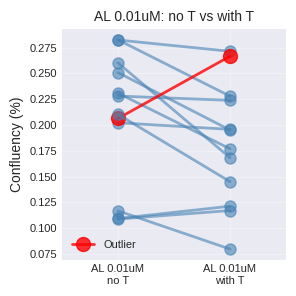

In [44]:
# Apply outlier detection to AL 0.01uM data
no_T_data = np.array(results_AL_0_01uM_no_T)
with_T_data = np.array(results_AL_0_01uM_with_T)

# Detect outliers
outlier_info = detect_outliers_pairwise(
    no_T_data, with_T_data, 
    method='zscore',  # or 'iqr' or 'grubbs'
    threshold=2
)

print("\n" + "="*60)
print("OUTLIER DETECTION - AL 0.01uM")
print("="*60)
print(f"Method: Z-score")
print(f"Threshold: 2")
print(f"Total pairs: {len(no_T_data)}")
print(f"Outliers detected: {outlier_info['n_outliers']}")

if outlier_info['n_outliers'] > 0:
    print(f"Outlier indices: {outlier_info['outlier_indices']}")
    print(f"Outlier differences: {outlier_info['outlier_differences']}")
    print(f"\nOutlier pairs:")
    for idx in outlier_info['outlier_indices']:
        print(f"  Pair {idx}: no_T={no_T_data[idx]:.2f}%, with_T={with_T_data[idx]:.2f}%, diff={no_T_data[idx]-with_T_data[idx]:.2f}%")

# Statistical comparison with and without outliers
print("\n" + "="*60)
print("COMPARISON: WITH vs WITHOUT OUTLIERS")
print("="*60)

# Original data (with outliers)
print("\nWith outliers:")
print(f"  n = {len(no_T_data)}")
print(f"  no_T: mean = {np.mean(no_T_data):.2f}%, SEM = {np.std(no_T_data, ddof=1)/np.sqrt(len(no_T_data)):.2f}%")
print(f"  with_T: mean = {np.mean(with_T_data):.2f}%, SEM = {np.std(with_T_data, ddof=1)/np.sqrt(len(with_T_data)):.2f}%")
t_stat_with_outliers, p_value_with_outliers = stats.ttest_rel(no_T_data, with_T_data)
print(f"  Paired t-test: t={t_stat_with_outliers:.4f}, p={p_value_with_outliers:.4e}")

# Cleaned data (without outliers)
if outlier_info['n_outliers'] > 0:
    no_T_clean = outlier_info['data1_clean']
    with_T_clean = outlier_info['data2_clean']
    
    print(f"\nWithout outliers:")
    print(f"  n = {len(no_T_clean)}")
    print(f"  no_T: mean = {np.mean(no_T_clean):.2f}%, SEM = {np.std(no_T_clean, ddof=1)/np.sqrt(len(no_T_clean)):.2f}%")
    print(f"  with_T: mean = {np.mean(with_T_clean):.2f}%, SEM = {np.std(with_T_clean, ddof=1)/np.sqrt(len(with_T_clean)):.2f}%")
    t_stat_clean, p_value_clean = stats.ttest_rel(no_T_clean, with_T_clean)
    print(f"  Paired t-test: t={t_stat_clean:.4f}, p={p_value_clean:.4e}")

# Visualize with outliers highlighted
fig, ax = plt.subplots(figsize=(3, 3))
is_normal = outlier_info['mask']

for i in range(len(no_T_data)):
    if is_normal[i]:  # Non-outlier
        ax.plot([1, 2], [no_T_data[i], with_T_data[i]], 'o-', alpha=0.6, 
                color='steelblue', linewidth=2, markersize=8)
    else:  # Outlier
        ax.plot([1, 2], [no_T_data[i], with_T_data[i]], 'o-', alpha=0.8, 
                color='red', linewidth=2, markersize=10, 
                label='Outlier' if i == outlier_info['outlier_indices'][0] else '')

ax.set_xlim(0.5, 2.5)
ax.set_xticks([1, 2])
ax.set_xticklabels(['AL 0.01uM\nno T', 'AL 0.01uM\nwith T'])
ax.set_ylabel('Confluency (%)')
ax.set_title('AL 0.01uM: no T vs with T')
ax.grid(True, alpha=0.3)

if outlier_info['n_outliers'] > 0:
    ax.legend()

plt.tight_layout()
plt.savefig('/home/user/Documents/Kinase_project/Imaging_result/figures/AL_0_01uM_outlier_detection.pdf', 
            bbox_inches='tight', dpi=300)
plt.show()


In [45]:
# DMSO and DMSO + T-cells wells

Well_numbers_dmso = [12,13,36,37]
Well_numbers_dmso_with_Tcells = [60,61,84,85]



# analyze_cell_confluency for all the wells above, and store results and do statitical comparison

results_dmso = []
results_dmso_with_Tcells = []

# loop through the experiment

for ex in [ex1, ex2, ex3]:
    print(f"\n--- Processing {ex} ---")
    
    if ex == ex3:
        Well_numbers_dmso = [12,36,60,84]
        Well_numbers_dmso_with_Tcells = [13,37,61,85]

    # Experiment - DMSO
    print(f"\n---  {ex} DMSO (no T-cells) ---")
    for well_number in Well_numbers_dmso:
        path = ex.format(well_number=well_number)
        result = analyze_cell_confluency(path)
        if result:
            results_dmso.append(result['proportion_covered'].astype(float))
            print(f"Well {well_number}: {result['proportion_covered']:.2f}%")

    # Experiment - DMSO + T-cells
    print(f"\n---  {ex} DMSO + T-cells ---")
    for well_number in Well_numbers_dmso_with_Tcells:
        path = ex1.format(well_number=well_number)
        result = analyze_cell_confluency(path)
        if result:
            results_dmso_with_Tcells.append(result['proportion_covered'].astype(float))
            print(f"Well {well_number}: {result['proportion_covered']:.2f}%")
        


--- Processing /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg ---

---  /home/user/Documents/Kinase_project/Imaging_result/Imaging_Results_BF_10_26_25/Experiment-184_s{well_number}.jpg DMSO (no T-cells) ---
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1608475
Proportion Covered (Confluency): 0.1885 (or 18.85%)
Well 12: 0.19%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1503494
Proportion Covered (Confluency): 0.1762 (or 17.62%)
Well 13: 0.18%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 2063973
Proportion Covered (Confluency): 0.2419 (or 24.19%)
Well 36: 0.24%
--- Cell Area / Proportion Results ---
Total Well Area (pixels): 8532165
Total Cell Area (pixels): 1524591
Proportion Covered (Confluency): 0.1787 (or 17.87%)
Well 37: 0.18%

---  /home/user/Documents/Kin

In [46]:


def plot_paired_comparison(data1, data2, label1, label2, outpath_base, 
                          color1='#023047', color2='#FF7F11', 
                          figsize=(2, 3), dpi=900):
    """
    Create paired comparison plots with statistical analysis.
    
    Parameters:
    -----------
    data1, data2 : array-like
        Paired data arrays to compare
    label1, label2 : str
        Labels for the two conditions
    outpath_base : str
        Base path for saving figures (without extension)
    color1, color2 : str
        Hex colors for the two conditions
    figsize : tuple
        Figure size in inches
    dpi : int
        Resolution for saved figures
    
    Returns:
    --------
    dict : Dictionary containing statistics (t_stat, p_value, mean_diff)
    """
    # Convert to numpy arrays
    data1 = np.array(data1)
    data2 = np.array(data2)
    
    # Calculate statistics
    differences = data1 - data2
    t_stat, p_value = stats.ttest_rel(data1, data2)
    
    # Print results
    print("=" * 60)
    print("PAIRED T-TEST RESULTS")
    print("=" * 60)
    print(f"\n{label1} Mean: {np.mean(data1):,.2f}")
    print(f"{label2} Mean: {np.mean(data2):,.2f}")
    print(f"Mean Difference: {np.mean(differences):,.2f}")
    print(f"\nt-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    # Determine significance annotation
    if p_value < 0.001:
        sig_text = '***'
    elif p_value < 0.01:
        sig_text = '**'
    elif p_value < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Figure 1: Paired data with connecting lines
    fig1 = plt.figure(figsize=figsize)
    for i in range(len(data1)):
        plt.plot([1, 2], [data1[i], data2[i]], 'o-', alpha=0.6, 
                linewidth=2, markersize=8, color='gray')
        plt.plot(1, data1[i], 'o', markersize=8, color=color1, alpha=0.8)
        plt.plot(2, data2[i], 'o', markersize=8, color=color2, alpha=0.8)
    
    plt.xlim(0.5, 2.5)
    plt.xticks([1, 2], [label1, label2])
    plt.ylabel('Value')
    plt.title('Paired Data Comparison')
    plt.grid(True, alpha=0.3)
    
    # Add mean lines
    plt.plot([0.9, 1.1], [np.mean(data1), np.mean(data1)], 
             'b-', linewidth=3, label='Mean')
    plt.plot([1.9, 2.1], [np.mean(data2), np.mean(data2)], 
             'b-', linewidth=3)
    plt.legend()
    
    # Add statistical annotation
    y_max_1 = max(max(data1), max(data2)) * 1.05
    plt.plot([1, 2], [y_max_1, y_max_1], 'k-', linewidth=1)
    plt.text(1.5, y_max_1 * 1.02, sig_text, ha='center', fontsize=12)
    plt.suptitle(f'Paired t-test: t={t_stat:.3f}, p={p_value:.4f}', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    # Save line plot
    for ext in ['pdf', 'png', 'svg']:
        plt.savefig(f"{outpath_base}_line.{ext}", 
                   bbox_inches='tight', transparent=True, dpi=dpi)
    plt.show()
    
    # Figure 2: Mean comparison with error bars
    fig2 = plt.figure(figsize=figsize)
    means = [np.mean(data1), np.mean(data2)]
    stds = [np.std(data1, ddof=1), np.std(data2, ddof=1)]
    sems = [s/np.sqrt(len(data1)) for s in stds]
    
    x_pos = [1, 2]
    plt.bar(x_pos, means, yerr=sems, capsize=10, 
            color=[color1, color2], alpha=0.7, 
            edgecolor='black', linewidth=2)
    
    plt.xticks(x_pos, [label1, label2])
    plt.ylabel('Mean Value')
    plt.title('Mean Comparison with Standard Error')
    plt.grid(True, alpha=0.3)
    
    # Add statistical annotation
    y_max_2 = max(means) + max(sems) * 1.5
    plt.plot([1, 2], [y_max_2, y_max_2], 'k-', linewidth=1)
    plt.text(1.5, y_max_2 * 1.02, sig_text, ha='center', fontsize=12)
    plt.suptitle(f'Paired t-test: t={t_stat:.3f}, p={p_value:.4f}', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    # Save bar plot
    for ext in ['pdf', 'png', 'svg']:
        plt.savefig(f"{outpath_base}_bar.{ext}", 
                   bbox_inches='tight', transparent=True, dpi=dpi)
    plt.show()
    
    return {
        't_stat': t_stat,
        'p_value': p_value,
        'mean_diff': np.mean(differences),
        'significance': sig_text
    }




In [ ]:
# Usage example:
stats_result = plot_paired_comparison(
    data1=results_dmso,
    data2=results_dmso_with_Tcells,
    label1='DMSO_NoT',
    label2='DMSO_WithT',
    outpath_base="/home/user/Documents/Kinase_project/Imaging_result/figures/dmso_comparison"
)

PAIRED T-TEST RESULTS

AL 0.01uM
no T Mean: 0.21
AL 0.01uM
with T Mean: 0.17
Mean Difference: 0.03

t-statistic: 3.1741
p-value: 0.0099


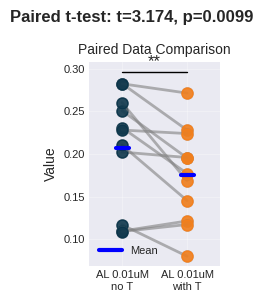

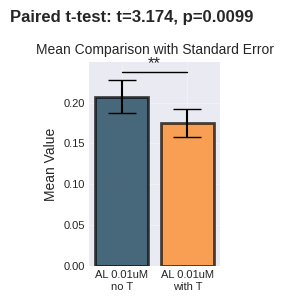

In [40]:
# Plot the cleaned data using the plotting function
if outlier_info['n_outliers'] > 0:
    stats_result = plot_paired_comparison(
        data1=no_T_clean,
        data2=with_T_clean,
        label1='AL 0.01uM\nno T',
        label2='AL 0.01uM\nwith T',
        outpath_base="/home/user/Documents/Kinase_project/Imaging_result/figures/AL_0_01uM_clean",
        color1='#023047',
        color2='#FF7F11'
    )
else:
    # If no outliers detected, plot original data
    stats_result = plot_paired_comparison(
        data1=no_T_data,
        data2=with_T_data,
        label1='AL 0.01uM\nno T',
        label2='AL 0.01uM\nwith T',
        outpath_base="/home/user/Documents/Kinase_project/Imaging_result/figures/AL_0_01uM",
        color1='#023047',
        color2='#FF7F11'
    )

In [ ]:
# End of code snippet